In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
import gc
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("./Data/used_car_train_20200313.csv", sep=" ", encoding="utf-8")
test = pd.read_csv("./Data/used_car_testB_20200421.csv", sep=" ", encoding="utf-8")

all_data = pd.concat([train, test], axis=0, ignore_index=True)

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

all_data = reduce_mem_usage(all_data)

Memory usage of dataframe is 49600128.00 MB
Memory usage after optimization is: 13600260.00 MB
Decreased by 72.6%


In [4]:
all_data["price"] = all_data["price"].fillna(-1).values
all_data["notRepairedDamage"] = all_data["notRepairedDamage"].replace("-", 0).astype("float32")

all_data.drop(["seller", "offerType"], axis=1, inplace=True)
# 纠正power异常
all_data.loc[:, "power"] = all_data["power"].apply(lambda x:x if x <= 600 else 600)

all_data['city'] = all_data['regionCode'].apply(lambda x : str(x)[:-3])
all_data.loc[:, "city"] = pd.to_numeric(all_data["city"], errors='coerce')
del all_data["regionCode"]

In [5]:
# 时间处理
regDate = pd.to_datetime(all_data["regDate"], format="%Y%m%d", errors="coerce")
creatDate = pd.to_datetime(all_data["creatDate"], format="%Y%m%d", errors="coerce")
time_now = pd.datetime.now()

all_data["creatDate_year"] = creatDate.dt.year
all_data["creatDate_month"] = creatDate.dt.month
all_data["creatDate_day"] = creatDate.dt.day
all_data["regDate_year"] = regDate.dt.year
all_data["regDate_month"] = regDate.dt.month
all_data["regDate_day"] = regDate.dt.day
all_data["used_time1"] = (creatDate - regDate).dt.days
all_data["used_time2"] = (time_now - creatDate).dt.days
all_data["used_time3"] = (time_now - regDate).dt.days

all_data["regDate_dayofweek"] = regDate.dt.dayofweek
all_data["creatDate_dayofweek"] = creatDate.dt.dayofweek

In [6]:
# v_feat异常处理
all_data.loc[:, "v_0"] = all_data.loc[:, "v_0"].apply(lambda x:x if x > 40 else 40)
all_data.loc[:, "v_1"] = all_data.loc[:, "v_1"].apply(lambda x:-1 if x < 0 else 1)
all_data.loc[:, "v_2"] = all_data.loc[:, "v_2"].apply(lambda x:x if x < 5 else 0)
all_data.loc[:, "v_5"] = all_data.loc[:, "v_5"].apply(lambda x:0.25 if x < 0.2 else x)
all_data.loc[:, "v_6"] = all_data.loc[:, "v_6"].apply(lambda x:0.1 if x < 0.05 else x)
all_data.loc[:, "v_7"] = all_data.loc[:, "v_7"].apply(lambda x:0.15 if x > 0.5 else x)
all_data.loc[:, "v_11"] = all_data.loc[:, "v_11"].apply(lambda x:0 if x > 5 else x)
all_data.loc[:, "v_13"] = all_data.loc[:, "v_13"].apply(lambda x:0 if x > 5 else x)
all_data.loc[:, "v_14"] = all_data.loc[:, "v_14"].apply(lambda x:0 if x > 5 else x)
all_data.loc[:, "v_14"] = all_data.loc[:, "v_14"].apply(lambda x:-5 if x < -5 else x)

In [7]:
#分桶操作,划分到区间内
def cut_group(df,cols,num_bins=50):
    for col in cols:
        all_range = int(df[col].max()-df[col].min())
        bin = [i*all_range/num_bins for i in range(all_range)]
        df[col+'_bin'] = pd.cut(df[col], bin, labels=False)   # 使用cut方法进行分箱
    return df

#分桶操作
cut_cols = ['used_time1', 'used_time2', 'used_time3']
all_data = cut_group(all_data,cut_cols,50)

#分桶操作
# all_data = cut_group(all_data,['kilometer'],10)

all_data = cut_group(all_data, ["power"], 30)

all_data.drop(['power'], axis=1, inplace=True)

### 保存预处理数据

In [9]:
all_data_01 = all_data.copy()  # 记录之前的数据

In [8]:
all_data.shape

(200000, 43)

In [52]:
all_data = all_data_01.copy()

In [8]:
# 删除有共线性的特征
# del_cols = ['v_8', 'v_4']
# all_data.drop(del_cols, axis=1, inplace=True)

# 特征工程

In [10]:
all_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'kilometer', 'notRepairedDamage', 'creatDate', 'price',
       'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9',
       'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'city', 'creatDate_year',
       'creatDate_month', 'creatDate_day', 'regDate_year', 'regDate_month',
       'regDate_day', 'used_time1', 'used_time2', 'used_time3',
       'regDate_dayofweek', 'creatDate_dayofweek', 'used_time1_bin',
       'used_time2_bin', 'used_time3_bin', 'power_bin'],
      dtype='object')

In [10]:
# 统计频率特征
count_features = [
    'regDate',
                  'model', 'brand', 'bodyType', 'fuelType',
                  'gearbox', 'kilometer', 'regDate_year', 'city', 
                  'used_time1_bin', 
                  'power_bin',]
for fea in count_features:
    all_data.loc[:, fea+"_count"] = all_data[fea].map(all_data[fea].value_counts())

In [11]:
all_data.shape

(200000, 54)

In [12]:
# Target编码特征
def target_feat(data, df, fea):
    Train_gb = df.groupby(fea)
    all_info = {}
    for kind, kind_data in Train_gb:
        info = {}
        kind_data = kind_data[kind_data['price'] > 0]
        info[fea + '_amount'] = len(kind_data)
        info[fea + '_price_max'] = kind_data.price.max()
        info[fea + '_price_median'] = kind_data.price.median()
        info[fea + '_price_min'] = kind_data.price.min()
        info[fea + '_price_sum'] = kind_data.price.sum()
        info[fea + '_price_std'] = kind_data.price.std()
        info[fea + '_price_skew'] = kind_data.price.skew()
        info[fea + '_price_kurt'] = kind_data.price.kurt()
        info[fea + '_price_average'] = round(kind_data.price.sum() / (len(kind_data) + 1), 2)
        all_info[kind] = info
    feat_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": fea})
    data = data.merge(feat_fe, how='left', on=fea)
    
    return data

train_data = all_data.loc[all_data["price"] != -1, :]
count_features = [
    'model', 'bodyType', 'fuelType', 
                  'brand'
                 ]
# count_features = ['brand']
for feat in count_features:
    all_data = target_feat(all_data, train_data, feat)

In [13]:
all_data.shape

(200000, 90)

In [14]:
# 根据分类变量统计连续型变量
def cross_cat_num(df,num_col,cat_col):
    for f1 in tqdm(cat_col):  # 对类别特征遍历
        g = df.groupby(f1, as_index=False)
        for f2 in tqdm(num_col):  # 对数值特征遍历
            feat = g[f2].agg({
                '{}_{}_max'.format(f1, f2): 'max', 
                '{}_{}_min'.format(f1, f2): 'min',
                '{}_{}_median'.format(f1, f2): 'median',
            })
            df = df.merge(feat, on=f1, how='left')
    return df

In [15]:
cross_cate_features = ['model','brand','regDate_year', 'power_bin', 'kilometer']
cross_num_features = ['v_3','v_0','v_12','v_14', 'v_10']
all_data = cross_cat_num(all_data, cross_num_features, cross_cate_features)

100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


In [18]:
all_data.shape

(200000, 309)

In [17]:
# # V 系列特征交叉
epsilon = 1e-5
func_dict = {
    'add':lambda x, y:x + y, 
    'mins':lambda x, y:x - y,
    'div':lambda x, y:x / (y + epsilon),
    'multi':lambda x, y:x * y
}
def auto_features_make(data, func_dict, col_list):
    for i in col_list:
        for j in col_list:
            for func_name, func in func_dict.items():
                func_features = func(data[i], data[j])
                col_func_features = "_".join([i, func_name, j])
                data[col_func_features] = func_features
    return data

features_make = ['v_3','v_0','v_12','v_6','v_11','v_8']
all_data = auto_features_make(all_data, func_dict, col_list=features_make)
print(all_data.shape)

# for i in ['v_' +str(t) for t in range(14)]:
#     for j in ['v_' +str(k) for k in range(int(i[2:])+1,15)]:
#         all_data[str(i)+'+'+str(j)] = all_data[str(i)]+all_data[str(j)]
# print(all_data.shape)

(200000, 309)


#### v系列补充特征

In [19]:
for i in ['model','brand', 'bodyType', 'fuelType','gearbox', 'power_bin',
          'kilometer', 'notRepairedDamage', 'city']:
    for j in ['v_' +str(i) for i in range(14)]:
        all_data[str(i)+'*'+str(j)] = all_data[i]*all_data[j]  
print(all_data.shape)

(200000, 435)


In [20]:
all_data[np.isinf(all_data)] = np.nan

In [21]:
# 距离特征定量
def genPower(df,col='kilometer'):
    df[col+"_genFeat1"]=(df['kilometer'] > 5).astype(int)
    df[col+"_genFeat2"]=(df['kilometer']> 10).astype(int)
    df[col+"_genFeat3"]=(df['kilometer']> 15).astype(int)
    return df
all_data = genPower(all_data)

In [22]:
# 类别特征交互
from scipy.stats import entropy
feat_cols = []
for f_pair in tqdm([['model', 'brand'], ['model', 'city'], ['brand', 'city']]):#+pair
    ### 共现次数
    all_data['_'.join(f_pair) + '_count'] = all_data.groupby(f_pair)['SaleID'].transform('count')
    
    ### nunique、熵
    all_data = all_data.merge(all_data.groupby(f_pair[0], as_index=False)[f_pair[1]].agg({
        '{}_{}_nunique'.format(f_pair[0], f_pair[1]): 'nunique',
        '{}_{}_ent'.format(f_pair[0], f_pair[1]): lambda x: entropy(x.value_counts() / x.shape[0])
    }), on=f_pair[0], how='left')
    
    all_data = all_data.merge(all_data.groupby(f_pair[1], as_index=False)[f_pair[0]].agg({
        '{}_{}_nunique'.format(f_pair[1], f_pair[0]): 'nunique',
        '{}_{}_ent'.format(f_pair[1], f_pair[0]): lambda x: entropy(x.value_counts() / x.shape[0])
    }), on=f_pair[1], how='left')
    
    ### 比例偏好
    all_data['{}_in_{}_prop'.format(f_pair[0], f_pair[1])] = all_data['_'.join(f_pair) + '_count'] / all_data[f_pair[1] + '_count']
    all_data['{}_in_{}_prop'.format(f_pair[1], f_pair[0])] = all_data['_'.join(f_pair) + '_count'] / all_data[f_pair[0] + '_count']
    
    feat_cols.extend([
        '_'.join(f_pair) + '_count',
        '{}_{}_nunique'.format(f_pair[0], f_pair[1]), '{}_{}_ent'.format(f_pair[0], f_pair[1]),
        '{}_{}_nunique'.format(f_pair[1], f_pair[0]), '{}_{}_ent'.format(f_pair[1], f_pair[0]),
        '{}_in_{}_prop'.format(f_pair[0], f_pair[1]), '{}_in_{}_prop'.format(f_pair[1], f_pair[0])
    ])

100%|██████████| 3/3 [00:08<00:00,  3.00s/it]


In [25]:
print(all_data.shape)

(200000, 527)


In [24]:
one_hot_list = ['bodyType','fuelType','gearbox','notRepairedDamage','creatDate_year', 
                'creatDate_month','regDate_month','regDate_year']
for col in one_hot_list:
    one_hot = pd.get_dummies(all_data[col])
    one_hot.columns = [col+'_'+str(i) for i in range(len(one_hot.columns))]
    all_data = pd.concat([all_data, one_hot],axis=1)
    
# all_data.drop(one_hot_list, axis=1, inplace=True)

In [26]:
# 填充缺失值 -- 众数
from sklearn.impute import SimpleImputer
imp_mode = SimpleImputer(strategy="most_frequent")

fill_features = [column for column in all_data.columns if all_data[column].isnull().sum() != 0]
for feature in fill_features:
    all_data.loc[:, feature] = imp_mode.fit_transform(all_data.loc[:, feature].values.reshape(-1, 1))

In [27]:
all_data_02 = all_data.copy()

In [72]:
all_data = all_data_02.copy()
all_data.shape

(200000, 249)

# 模型验证

In [28]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import make_scorer
from lofo import FLOFOImportance
from sklearn.metrics import make_scorer

In [29]:
all_data1 = all_data.copy()

# all_data1.drop("SaleID", axis=1, inplace=True)

In [40]:
# 准备数据
train_data = all_data1.loc[all_data1["price"] != -1, :]
train_y = train_data["price"]
train_data.drop("price", axis=1, inplace=True)

test_data = all_data1.loc[all_data["price"] == -1, :]
test_data.drop("price", axis=1, inplace=True)

train_y = np.log1p(train_y)

In [52]:
train_columns = train_data.columns
target_column = 'price'
train_data["price"] = train_y


### lgb

(150000, 526)

In [42]:
params = {
    'num_leaves': 50,
    'objective': 'regression_l1',
    'max_depth': -1,
    'learning_rate': 0.1,
    'min_split_gain': 0.1,       # 相当于xgboost中的gamma
    'min_child_samples':2,
    "boosting": "gbdt",
    "feature_fraction": 1,      # 弱学习器随机采样比例，相当于subsamples
    "bagging_freq": 1,            # k次执行一次采样
    "bagging_fraction": 0.7,
    "bagging_seed": 11,
    "lambda_l1": 0.3,
    # "lambda_l2": 3.5,
    "verbosity": -1,
    "nthread": 4,                 # 线程
    'metric': 'mae',
    "random_state": 2019,         # 随机种子
          }
categorical_features = ['bodyType','fuelType', 'gearbox', 'notRepairedDamage', 'regDate_year']
# categorical_features = ['regDate', 'model', 'brand', 'bodyType', 'fuelType',
#                         'gearbox', 'kilometer', 'regDate_year', 'city', 'used_time1_bin', 
#                         'power_bin', 'notRepairedDamage']
folds = KFold(n_splits=5)
Y_pred = np.zeros(test_data.shape[0]) 
for fold_, (tr_idx, val_idx) in tqdm(enumerate(folds.split(train_data))):
    tr_data = lgb.Dataset(train_data.iloc[tr_idx], label=train_y.iloc[tr_idx])
    val_data = lgb.Dataset(train_data.iloc[val_idx], label=train_y.iloc[val_idx])
    num_round = 900
    clf = lgb.train(params, 
                    tr_data,
                    num_round,
                    valid_sets=[tr_data, val_data],
                    categorical_feature = categorical_features,
                    verbose_eval=100,
                    early_stopping_rounds=20)
# ----------------------------------------------------------------------------验证
    # Y_pred = clf.predict(train_data.iloc[val_idx])
    # score_mae = MAE(train_y.iloc[val_idx], Y_pred)
    # score_mse = MSE(train_y.iloc[val_idx], Y_pred)
    # print("MAE:",score_mae)
    # print("MSE:",score_mse)
# ----------------------------------------------------------------------------预测----------
    Y_pred += clf.predict(test_data, num_iteration=clf.best_iteration)/folds.n_splits    
Y_pred = np.expm1(Y_pred)  
Y_pred
 

0it [00:00, ?it/s]

Training until validation scores don't improve for 20 rounds
[100]	training's l1: 0.130296	valid_1's l1: 0.134409
[200]	training's l1: 0.118564	valid_1's l1: 0.124652
[300]	training's l1: 0.113247	valid_1's l1: 0.121249
[400]	training's l1: 0.109577	valid_1's l1: 0.119485
[500]	training's l1: 0.106712	valid_1's l1: 0.118296
[600]	training's l1: 0.104454	valid_1's l1: 0.117399
[700]	training's l1: 0.102185	valid_1's l1: 0.116843
[800]	training's l1: 0.10034	valid_1's l1: 0.11646
[900]	training's l1: 0.098477	valid_1's l1: 0.116093
Did not meet early stopping. Best iteration is:
[900]	training's l1: 0.098477	valid_1's l1: 0.116093


1it [02:50, 170.01s/it]

Training until validation scores don't improve for 20 rounds
[100]	training's l1: 0.130622	valid_1's l1: 0.136295
[200]	training's l1: 0.118726	valid_1's l1: 0.126343
[300]	training's l1: 0.112924	valid_1's l1: 0.122429
[400]	training's l1: 0.109347	valid_1's l1: 0.120759
[500]	training's l1: 0.106523	valid_1's l1: 0.1197
[600]	training's l1: 0.103892	valid_1's l1: 0.118923
[700]	training's l1: 0.101977	valid_1's l1: 0.118342
[800]	training's l1: 0.100218	valid_1's l1: 0.117952
[900]	training's l1: 0.0987519	valid_1's l1: 0.117641
Did not meet early stopping. Best iteration is:
[900]	training's l1: 0.0987519	valid_1's l1: 0.117641


2it [05:18, 157.44s/it]

Training until validation scores don't improve for 20 rounds
[100]	training's l1: 0.13049	valid_1's l1: 0.136213
[200]	training's l1: 0.118348	valid_1's l1: 0.126061
[300]	training's l1: 0.112868	valid_1's l1: 0.122528
[400]	training's l1: 0.10921	valid_1's l1: 0.120732
[500]	training's l1: 0.106347	valid_1's l1: 0.119714
[600]	training's l1: 0.103532	valid_1's l1: 0.118952
[700]	training's l1: 0.101503	valid_1's l1: 0.118426
[800]	training's l1: 0.0998012	valid_1's l1: 0.117946
[900]	training's l1: 0.098033	valid_1's l1: 0.117631
Did not meet early stopping. Best iteration is:
[900]	training's l1: 0.098033	valid_1's l1: 0.117631


3it [07:50, 154.86s/it]

Training until validation scores don't improve for 20 rounds
[100]	training's l1: 0.131055	valid_1's l1: 0.132839
[200]	training's l1: 0.119326	valid_1's l1: 0.123537
[300]	training's l1: 0.113677	valid_1's l1: 0.120045
[400]	training's l1: 0.109945	valid_1's l1: 0.118317
[500]	training's l1: 0.107016	valid_1's l1: 0.117375
[600]	training's l1: 0.104435	valid_1's l1: 0.11653
[700]	training's l1: 0.102103	valid_1's l1: 0.116023
[800]	training's l1: 0.100262	valid_1's l1: 0.11558
[900]	training's l1: 0.0985699	valid_1's l1: 0.115232
Did not meet early stopping. Best iteration is:
[900]	training's l1: 0.0985699	valid_1's l1: 0.115232


4it [10:22, 153.76s/it]

Training until validation scores don't improve for 20 rounds
[100]	training's l1: 0.130279	valid_1's l1: 0.135551
[200]	training's l1: 0.118647	valid_1's l1: 0.12563
[300]	training's l1: 0.113283	valid_1's l1: 0.122021
[400]	training's l1: 0.109751	valid_1's l1: 0.120199
[500]	training's l1: 0.10661	valid_1's l1: 0.118928
[600]	training's l1: 0.104121	valid_1's l1: 0.118049
[700]	training's l1: 0.101972	valid_1's l1: 0.117437
[800]	training's l1: 0.100016	valid_1's l1: 0.116994
[900]	training's l1: 0.0983964	valid_1's l1: 0.11667
Did not meet early stopping. Best iteration is:
[900]	training's l1: 0.0983964	valid_1's l1: 0.11667


5it [13:20, 160.13s/it]


array([1255.32870581, 1925.12101199, 8400.12912683, ..., 5471.20921814,
       4751.12938996, 5254.05666013])

In [37]:
train_data = all_data1.loc[all_data1["price"] != -1, :]
train_y = train_data["price"]
train_data.drop(["price"], axis=1, inplace=True)

print(train_data.shape)
print(train_y.shape)

(150000, 366)
(150000,)


In [38]:
train_X, test_X, trainy, testy = train_test_split(train_data, train_y, test_size=0.3, random_state=0)
trainyy = np.log1p(trainy)

params = {
    'num_leaves': 50, 'objective': 'regression_l1', 'max_depth': -1, 'learning_rate': 0.1,
    'min_split_gain': 0.1, 'min_child_samples':2, "boosting": "gbdt", "feature_fraction": 1,     
    "bagging_freq": 1, "bagging_fraction": 1, "bagging_seed": 11, "lambda_l1": 0.5,
    "lambda_l2": 3.5,"verbosity": -1,"nthread": 4, 'metric': 'mae',"random_state": 2019
         }
# categorical_features = ['bodyType','fuelType', 'gearbox', 
#                         'notRepairedDamage',
#                         'regDate_year']

folds = KFold(n_splits=5)
Ypred = np.zeros(test_X.shape[0]) 
for fold_, (tr_idx, val_idx) in tqdm(enumerate(folds.split(train_X))):
    tr_data = lgb.Dataset(train_X.iloc[tr_idx], label=trainyy.iloc[tr_idx])
    val_data = lgb.Dataset(train_X.iloc[val_idx], label=trainyy.iloc[val_idx])
    num_round = 900
    clf = lgb.train(params, tr_data, num_round,
                    valid_sets=[tr_data, val_data],
                    # categorical_feature = categorical_features,
                    verbose_eval=100, early_stopping_rounds=20)
# ----------------------------------------------------------------------------预测----------
    Ypred += clf.predict(test_X, num_iteration=clf.best_iteration)/folds.n_splits    
Ypred = np.expm1(Ypred)  
Ypred
 

0it [00:00, ?it/s]

Training until validation scores don't improve for 20 rounds
[100]	training's l1: 0.130348	valid_1's l1: 0.135229
[200]	training's l1: 0.118394	valid_1's l1: 0.125933
[300]	training's l1: 0.112693	valid_1's l1: 0.122916
[400]	training's l1: 0.108667	valid_1's l1: 0.121212
[500]	training's l1: 0.106103	valid_1's l1: 0.120392
[600]	training's l1: 0.103679	valid_1's l1: 0.119556
[700]	training's l1: 0.101924	valid_1's l1: 0.11916
[800]	training's l1: 0.100224	valid_1's l1: 0.118787
[900]	training's l1: 0.0989679	valid_1's l1: 0.118601
Did not meet early stopping. Best iteration is:
[900]	training's l1: 0.0989679	valid_1's l1: 0.118601


1it [02:39, 159.79s/it]

Training until validation scores don't improve for 20 rounds
[100]	training's l1: 0.129988	valid_1's l1: 0.134309
[200]	training's l1: 0.118027	valid_1's l1: 0.125142
[300]	training's l1: 0.112499	valid_1's l1: 0.122281
[400]	training's l1: 0.108817	valid_1's l1: 0.120875
[500]	training's l1: 0.106041	valid_1's l1: 0.119998
[600]	training's l1: 0.103893	valid_1's l1: 0.119567
[700]	training's l1: 0.10176	valid_1's l1: 0.119074
[800]	training's l1: 0.100293	valid_1's l1: 0.118869
[900]	training's l1: 0.0988533	valid_1's l1: 0.118541
Did not meet early stopping. Best iteration is:
[900]	training's l1: 0.0988533	valid_1's l1: 0.118541


2it [05:07, 152.55s/it]

Training until validation scores don't improve for 20 rounds
[100]	training's l1: 0.130041	valid_1's l1: 0.139447
[200]	training's l1: 0.118321	valid_1's l1: 0.129845
[300]	training's l1: 0.1125	valid_1's l1: 0.126542
[400]	training's l1: 0.107845	valid_1's l1: 0.124449
[500]	training's l1: 0.105205	valid_1's l1: 0.123518
[600]	training's l1: 0.102733	valid_1's l1: 0.122888
[700]	training's l1: 0.100271	valid_1's l1: 0.122507
Early stopping, best iteration is:
[751]	training's l1: 0.0992822	valid_1's l1: 0.122323


3it [08:44, 182.00s/it]

Training until validation scores don't improve for 20 rounds
[100]	training's l1: 0.12946	valid_1's l1: 0.13643
[200]	training's l1: 0.117823	valid_1's l1: 0.127583
[300]	training's l1: 0.112554	valid_1's l1: 0.124616
[400]	training's l1: 0.108338	valid_1's l1: 0.122987
[500]	training's l1: 0.105066	valid_1's l1: 0.122031
[600]	training's l1: 0.102857	valid_1's l1: 0.121394
[700]	training's l1: 0.101511	valid_1's l1: 0.121129
[800]	training's l1: 0.099805	valid_1's l1: 0.120721
Early stopping, best iteration is:
[816]	training's l1: 0.0995662	valid_1's l1: 0.120691


4it [11:01, 164.39s/it]

Training until validation scores don't improve for 20 rounds
[100]	training's l1: 0.129478	valid_1's l1: 0.136097
[200]	training's l1: 0.117513	valid_1's l1: 0.127355
[300]	training's l1: 0.111987	valid_1's l1: 0.12444
[400]	training's l1: 0.107752	valid_1's l1: 0.122785
[500]	training's l1: 0.105108	valid_1's l1: 0.121904
[600]	training's l1: 0.103197	valid_1's l1: 0.121492
[700]	training's l1: 0.101247	valid_1's l1: 0.120999
[800]	training's l1: 0.0999931	valid_1's l1: 0.120683
[900]	training's l1: 0.0985055	valid_1's l1: 0.120509
Did not meet early stopping. Best iteration is:
[900]	training's l1: 0.0985055	valid_1's l1: 0.120509


5it [13:11, 158.22s/it]


array([ 7963.63069819,  1128.66118359,  9974.2894505 , ...,
         995.41058179,  1753.81923948, 10056.91765468])

In [40]:
# testy = np.expm1(testy)

In [39]:
score_mae = MAE(testy, Ypred)
score_mse = MSE(testy, Ypred)
print("MAE:",score_mae)
print("MSE:",score_mse)

MAE: 491.741683873357
MSE: 1537121.17863959


# CatBoost

In [39]:
from catboost import CatBoostRegressor as Cat

In [40]:
train_X, test_X, trainy, testy = train_test_split(train_data, train_y, test_size=0.3, random_state=0)
trainyy = np.log1p(trainy)
testyy = np.log1p(testy)
cate_feats = ['model','brand','name','regDate', 'creatDate','bodyType', 'fuelType',
            'gearbox', 'kilometer', 'regDate_year', 'city', 'used_time1_bin', 
            'power_bin', 'notRepairedDamage']
params = {'learning_rate': 0.1, 
          'depth': 13, 
          'od_type': 'Iter', 
          'od_wait': 50, 
          'l2_leaf_reg': 5,
          'random_seed': 11, 
          'rsm': 1,
          'one_hot_max_size': 8}
model = Cat(iterations=200, eval_metric='MAE', **params)
model.fit(train_X, trainyy, cat_features=cate_feats, 
         eval_set=(test_X, testyy), use_best_model=True)
Y_pred = model.predict(test_X)
Y_pred= np.expm1(Y_pred) 
Y_pred

0:	learn: 0.9018831	test: 0.9048925	best: 0.9048925 (0)	total: 13.4s	remaining: 44m 28s
1:	learn: 0.8224443	test: 0.8251039	best: 0.8251039 (1)	total: 26.6s	remaining: 43m 51s
2:	learn: 0.7499953	test: 0.7524761	best: 0.7524761 (2)	total: 38.5s	remaining: 42m 9s
3:	learn: 0.6851059	test: 0.6871371	best: 0.6871371 (3)	total: 50s	remaining: 40m 51s
4:	learn: 0.6265652	test: 0.6282873	best: 0.6282873 (4)	total: 1m 1s	remaining: 40m 15s


KeyboardInterrupt: 

In [37]:
cate_feats = ['model','brand','name','regDate', 'creatDate','bodyType', 'fuelType',
            'gearbox', 'kilometer', 'regDate_year', 'city', 'used_time1_bin', 
            'power_bin', 'notRepairedDamage']

In [38]:
train_data[cate_feats] = train_data[cate_feats].astype('int')

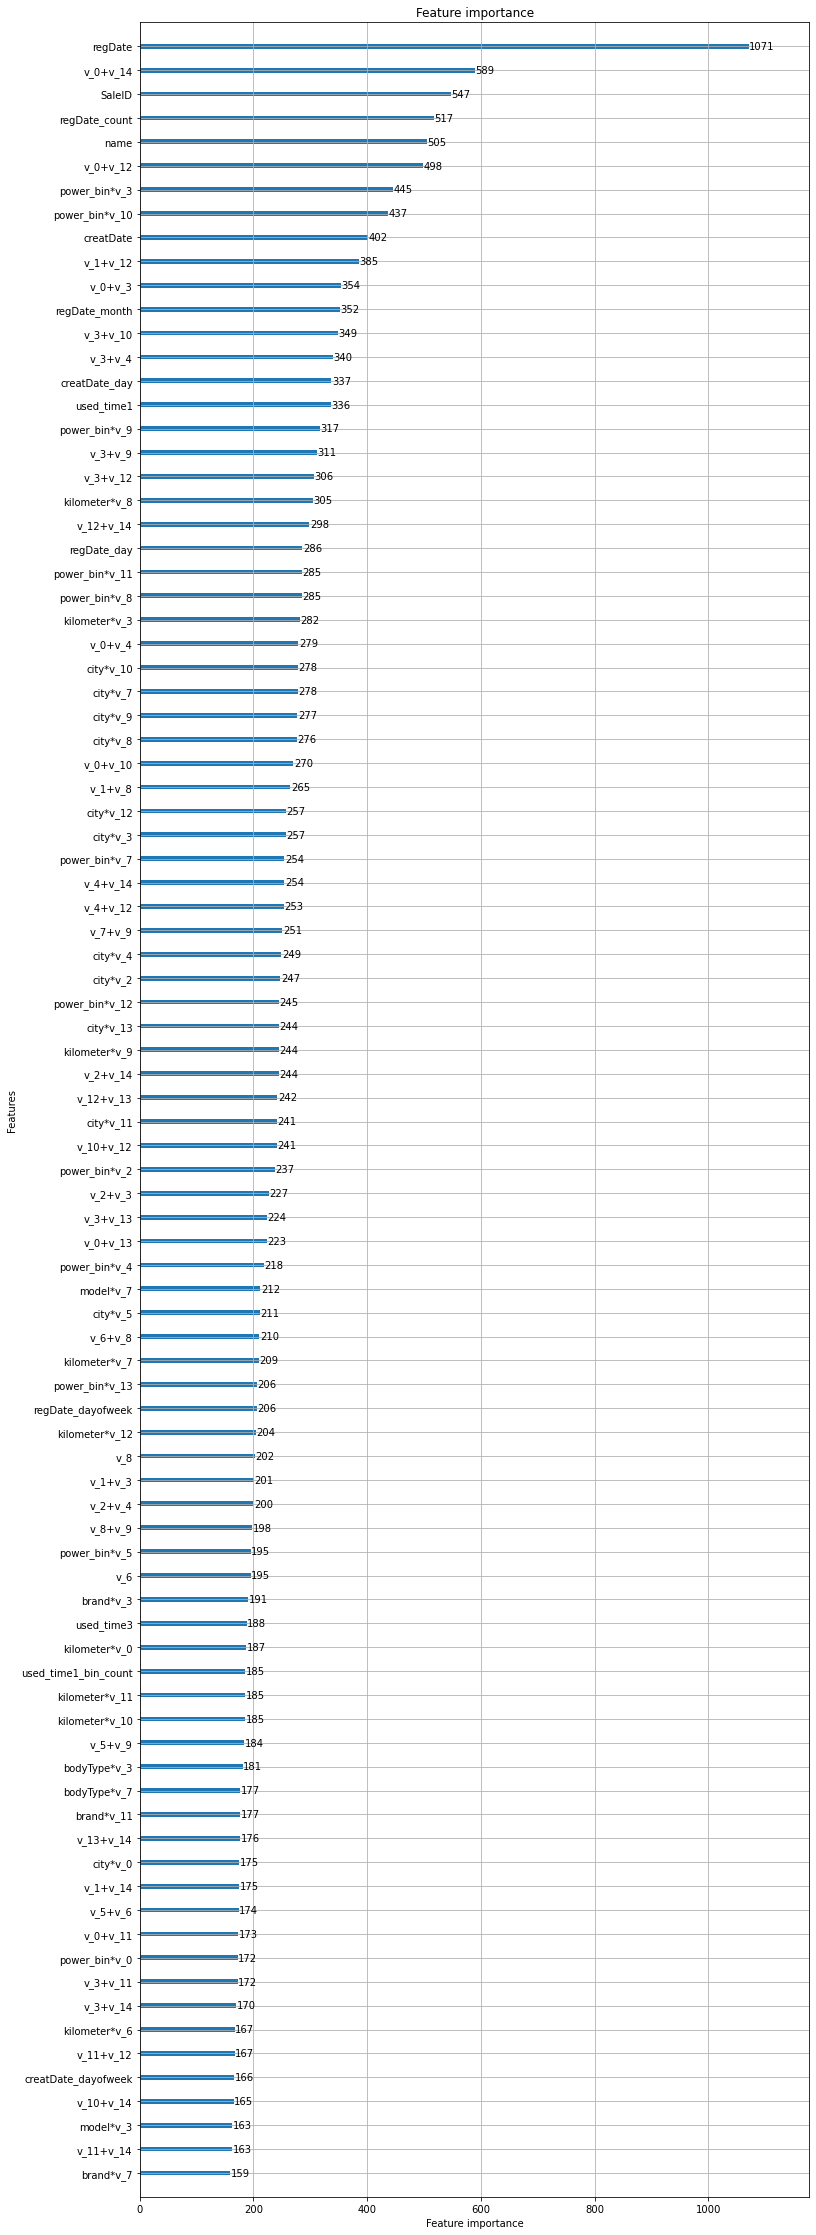

In [38]:
from lightgbm import plot_importance
fig, ax = plt.subplots(figsize=(12, 40))
plot_importance(clf, ax=ax, max_num_features=90)
plt.show()

In [56]:
train_data = all_data1.loc[all_data["price"] != -1, :]
correlation = train_data.corr().abs()
X = correlation['price'].sort_values(ascending=False)

[*zip(pd.DataFrame(X).index, X)]

[('price', 1.0),
 ('Ridge_feature', 0.966459101386487),
 ('v_12_add_v_0', 0.7836179701046292),
 ('v_0_add_v_12', 0.7836179701046292),
 ('v_0_mins_v_3', 0.7699762878180915),
 ('v_3_mins_v_0', 0.7699762878180915),
 ('v_3_multi_v_0', 0.7530715047062833),
 ('v_0_multi_v_3', 0.7530715047062833),
 ('v_12_mins_v_3', 0.7454305513466345),
 ('v_3_mins_v_12', 0.7454305513466345),
 ('v_3_multi_v_6', 0.7434105435314313),
 ('v_6_multi_v_3', 0.7434105435314313),
 ('v_3_mins_v_6', 0.7314282114819792),
 ('v_6_mins_v_3', 0.7314282114819792),
 ('v_3_add_v_3', 0.7309465715424538),
 ('v_3', 0.7309465715424538),
 ('v_6_add_v_3', 0.7304461054239424),
 ('v_3_add_v_6', 0.7304461054239424),
 ('v_0_multi_v_0', 0.7298893603386798),
 ('v_0_multi_v_12', 0.7271686714680172),
 ('v_12_multi_v_0', 0.7271686714680172),
 ('v_6_add_v_0', 0.7160861242579151),
 ('v_0_add_v_6', 0.7160861242579151),
 ('v_0', 0.7160557970931893),
 ('v_0_add_v_0', 0.7160557970931893),
 ('v_0_mins_v_6', 0.7160095296314942),
 ('v_6_mins_v_0', 0.7

In [30]:
# 删除共线性特征
print(all_data1.shape)
del_feat = [feat for feat in all_data1.columns if all_data1[feat].nunique() == 1]
all_data1.drop(del_feat, axis=1, inplace=True)
print(all_data1.shape)

(200000, 527)
(200000, 517)


In [36]:
# 过滤掉相关性小于 0.1 的特征
train_data = all_data1.loc[all_data["price"] != -1, :]
print(all_data1.shape)
threshold = 0.08
corr_matrix = train_data.corr().abs()
drop_col = corr_matrix[corr_matrix["price"] < threshold].index
all_data1.drop(drop_col, axis=1, inplace=True)
print(all_data1.shape)


(200000, 517)
(200000, 367)


In [42]:
all_data1[np.isinf(all_data1)] = np.nan

In [43]:
# 填充缺失值 -- 众数
from sklearn.impute import SimpleImputer
imp_mode = SimpleImputer(strategy="most_frequent")

fill_features = [column for column in all_data1.columns if all_data1[column].isnull().sum() != 0]
for feature in fill_features:
    all_data1.loc[:, feature] = imp_mode.fit_transform(all_data1.loc[:, feature].values.reshape(-1, 1))

In [44]:
# 过滤掉方差为 0 的特征
from sklearn.feature_selection import VarianceThreshold as VT
print(all_data1.shape)
selector = VT()
all_data1 = selector.fit_transform(all_data1)
print(all_data1.shape)

(200000, 335)
(200000, 335)


In [44]:
all_data_03 = all_data1.copy()  # 保存未归一化的数据

In [76]:
all_data1 = all_data_03.copy()

In [79]:
all_data1.shape

(200000, 333)

## 归一化

In [23]:
from sklearn import preprocessing
features_columns = [col for col in all_data1.columns if col not in ['price']]
Mmax = preprocessing.MinMaxScaler()
Mmax = Mmax.fit(all_data1[features_columns])
all_data_scaler = Mmax.transform(all_data1[features_columns])
all_data_scaler = pd.DataFrame(all_data_scaler)
all_data_scaler.columns = features_columns
all_data_scaler['price'] = all_data['price'].values

all_data1 = all_data_scaler.copy()
print(all_data1.shape)

(200000, 43)


# Lgb特征选择

In [43]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data, train_y, test_size=0.3, random_state=0)

train_matrix = lgb.Dataset(X_train, label=y_train)
test_matrix = lgb.Dataset(X_test, label=y_test)
params = {
    'num_leaves': 50,
    'objective': 'regression_l1',
    'max_depth': -1,
    'learning_rate': 0.1,
    'min_split_gain': 0.1,       # 相当于xgboost中的gamma
    'min_child_samples':2,
    "boosting": "gbdt",
    "feature_fraction": 1,      # 弱学习器随机采样比例，相当于subsamples
    "bagging_freq": 1,            # k次执行一次采样
    "bagging_fraction": 0.7,
    "bagging_seed": 11,
    "lambda_l1": 0.3,
    # "lambda_l2": 3.5,
    "verbosity": -1,
    "nthread": 4,                 # 线程
    'metric': 'mae',
    "random_state": 2019,   
}
num_round = 700
clf = lgb.train(params, 
                  train_matrix, 
                  num_round, 
                  valid_sets= test_matrix, 
                  verbose_eval=100,
                  early_stopping_rounds=20)

def lgb_transform(data, model, topK):
    
    train_df = pd.DataFrame(data)
    train_df.columns = range(data.shape[1])
    
    features_import = pd.DataFrame()
    features_import['importance'] = model.feature_importance()
    features_import['col'] = range(data.shape[1])
    
    features_import = features_import.sort_values(['importance'], ascending=0).head(topK)
    
    sel_col = list(features_import.col)
    
    train_sel = train_df[sel_col]

    
    return train_sel


print('筛选前：', all_data1.shape)
all_data1.drop('price', axis=1, inplace=True)
all_data1 = lgb_transform(all_data1, clf, 300)
all_data1['price'] = all_data['price'].values
print('筛选后：', all_data1.shape)

In [30]:
all_data1.shape

(200000, 771)

In [45]:
all_data11 = all_data1.copy()

In [98]:
all_data1 = all_data11.copy()

In [97]:
all_data11.shape

(200000, 301)

In [22]:
y = np.log1p(train_y)

### Ridge特征

In [23]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression as LR

clf5 = Ridge(alpha=1.0)
# clf5 = LR()
clf5 = clf5.fit(train_data, y)

# all_data2 = all_data1.drop("price", axis=1, inplace=False)
Ypred = clf5.predict(train_data)
Ypred

Ridge_feature = np.expm1(Ypred)
len(Ridge_feature)

Ridge_feature

array([1167.15324201, 2628.79438935, 7765.18241967, ..., 7634.57594441,
       5105.78391776, 3683.3016052 ])

In [88]:
all_data1["price"] = all_data["price"].values

In [33]:
all_data1["Ridge_feature"] = Ridge_feature 
# all_data1["Y_pred"] = Y_pred.values()
# all_data1["price"] = all_data["price"].values
# all_data_part2 = all_data1.copy()

ValueError: Length of values (150000) does not match length of index (200000)

In [24]:
train_data["Ridge_feature"] = Ridge_feature 

In [49]:
all_data1.drop("Ridge_feature", axis=1, inplace=True)

In [68]:
# 单独归一化
# from sklearn import preprocessing
# features_columns = ['Ridge_feature']
# Mmax = preprocessing.MinMaxScaler()
# Mmax = Mmax.fit(all_data1[features_columns])
# all_data_scaler = Mmax.transform(all_data1[features_columns])
# all_data_scaler = pd.DataFrame(all_data_scaler)
# all_data_scaler.columns = features_columns
# all_data_scaler['price'] = all_data['price'].values

# all_data1 = all_data_scaler.copy()
# print(all_data1.shape)

all_data1[888] = ((all_data1["Ridge_feature"] - np.min(all_data1["Ridge_feature"])) / 
                        (np.max(all_data1["Ridge_feature"]) - np.min(all_data1["Ridge_feature"])))

In [62]:
import gc
del all_data1
gc.collect()

NameError: name 'all_data1' is not defined

# 模型输出

In [43]:
sample = pd.read_csv("./Data/used_car_sample_submit.csv")
sample["price"] = Y_pred
sample.to_csv("./Output_Data/Lgb_Pred9.csv", index=None)

# PCA

In [39]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=0.999)
print(all_data1.shape)
all_data1.drop('price', axis=1, inplace=True)
all_data1 = pca.fit_transform(all_data1)
print(all_data1.shape)
# all_data1['price'] = all_data['price'].values

all_data1 = pd.DataFrame(all_data1)
all_data1['price'] = all_data['price'].values

(200000, 775)
(200000, 193)


# 高基数编码mean_encoding

In [35]:
pip install itertools

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools


In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from itertools import product
 
class MeanEncoder:
    def __init__(self, categorical_features, n_splits=5, target_type='classification', prior_weight_func=None):
        """
        :param categorical_features: list of str, the name of the categorical columns to encode
        :param n_splits: the number of splits used in mean encoding
        :param target_type: str, 'regression' or 'classification'
        :param prior_weight_func:
        a function that takes in the number of observations, and outputs prior weight
        when a dict is passed, the default exponential decay function will be used:
        k: the number of observations needed for the posterior to be weighted equally as the prior
        f: larger f --> smaller slope
        """
 
        self.categorical_features = categorical_features
        self.n_splits = n_splits
        self.learned_stats = {}
 
        if target_type == 'classification':
            self.target_type = target_type
            self.target_values = []
        else:
            self.target_type = 'regression'
            self.target_values = None
 
        if isinstance(prior_weight_func, dict):
            self.prior_weight_func = eval('lambda x: 1 / (1 + np.exp((x - k) / f))', dict(prior_weight_func, np=np))
        elif callable(prior_weight_func):
            self.prior_weight_func = prior_weight_func
        else:
            self.prior_weight_func = lambda x: 1 / (1 + np.exp((x - 2) / 1))
 
    @staticmethod
    def mean_encode_subroutine(X_train, y_train, X_test, variable, target, prior_weight_func):
        X_train = X_train[[variable]].copy()
        X_test = X_test[[variable]].copy()
 
        if target is not None:
            nf_name = '{}_pred_{}'.format(variable, target)
            X_train['pred_temp'] = (y_train == target).astype(int)  # classification
        else:
            nf_name = '{}_pred'.format(variable)
            X_train['pred_temp'] = y_train  # regression
        prior = X_train['pred_temp'].mean()
 
        col_avg_y = X_train.groupby(by=variable, axis=0)['pred_temp'].agg({'mean': 'mean', 'beta': 'size'})
        col_avg_y['beta'] = prior_weight_func(col_avg_y['beta'])
        col_avg_y[nf_name] = col_avg_y['beta'] * prior + (1 - col_avg_y['beta']) * col_avg_y['mean']
        col_avg_y.drop(['beta', 'mean'], axis=1, inplace=True)
 
        nf_train = X_train.join(col_avg_y, on=variable)[nf_name].values
        nf_test = X_test.join(col_avg_y, on=variable).fillna(prior, inplace=False)[nf_name].values
 
        return nf_train, nf_test, prior, col_avg_y
 
    def fit_transform(self, X, y):
        """
        :param X: pandas DataFrame, n_samples * n_features
        :param y: pandas Series or numpy array, n_samples
        :return X_new: the transformed pandas DataFrame containing mean-encoded categorical features
        """
        X_new = X.copy()
        if self.target_type == 'classification':
            skf = StratifiedKFold(self.n_splits)
        else:
            skf = KFold(self.n_splits)
 
        if self.target_type == 'classification':
            self.target_values = sorted(set(y))
            self.learned_stats = {'{}_pred_{}'.format(variable, target): [] for variable, target in
                                  product(self.categorical_features, self.target_values)}
            for variable, target in product(self.categorical_features, self.target_values):
                nf_name = '{}_pred_{}'.format(variable, target)
                X_new.loc[:, nf_name] = np.nan
                for large_ind, small_ind in skf.split(y, y):
                    nf_large, nf_small, prior, col_avg_y = MeanEncoder.mean_encode_subroutine(
                        X_new.iloc[large_ind], y.iloc[large_ind], X_new.iloc[small_ind], variable, target, self.prior_weight_func)
                    X_new.iloc[small_ind, -1] = nf_small
                    self.learned_stats[nf_name].append((prior, col_avg_y))
        else:
            self.learned_stats = {'{}_pred'.format(variable): [] for variable in self.categorical_features}
            for variable in self.categorical_features:
                nf_name = '{}_pred'.format(variable)
                X_new.loc[:, nf_name] = np.nan
                for large_ind, small_ind in skf.split(y, y):
                    nf_large, nf_small, prior, col_avg_y = MeanEncoder.mean_encode_subroutine(
                        X_new.iloc[large_ind], y.iloc[large_ind], X_new.iloc[small_ind], variable, None, self.prior_weight_func)
                    X_new.iloc[small_ind, -1] = nf_small
                    self.learned_stats[nf_name].append((prior, col_avg_y))
        return X_new
 
    def transform(self, X):
        """
        :param X: pandas DataFrame, n_samples * n_features
        :return X_new: the transformed pandas DataFrame containing mean-encoded categorical features
        """
        X_new = X.copy()
 
        if self.target_type == 'classification':
            for variable, target in product(self.categorical_features, self.target_values):
                nf_name = '{}_pred_{}'.format(variable, target)
                X_new[nf_name] = 0
                for prior, col_avg_y in self.learned_stats[nf_name]:
                    X_new[nf_name] += X_new[[variable]].join(col_avg_y, on=variable).fillna(prior, inplace=False)[
                        nf_name]
                X_new[nf_name] /= self.n_splits
        else:
            for variable in self.categorical_features:
                nf_name = '{}_pred'.format(variable)
                X_new[nf_name] = 0
                for prior, col_avg_y in self.learned_stats[nf_name]:
                    X_new[nf_name] += X_new[[variable]].join(col_avg_y, on=variable).fillna(prior, inplace=False)[
                        nf_name]
                X_new[nf_name] /= self.n_splits
 
        return X_new

In [33]:
# 高基数定性特征：name汽车交易名称，brand汽车品牌，regionCode地区编码
class_list = ['model','brand','name','regionCode']+['regDate', 'creatDate']
MeanEnocodeFeature = class_list   # 声明需要平均数编码的特征
ME = MeanEncoder(MeanEnocodeFeature,target_type='regression') # 声明平均数编码的类

In [34]:
train_data = ME.fit_transform(train_data,train_y)   # 对训练数据集的X和y进行拟合

SpecificationError: nested renamer is not supported

In [35]:
test_data = ME.transform(test_data)#对测试集进行编码

SpecificationError: nested renamer is not supported

In [26]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
sfs = SFS(LinearRegression(),
           k_features=500,
           forward=True,
           floating=False,
           scoring = 'r2',
           cv = 0)

In [27]:
sfs.fit(train_data, train_y)
sfs.k_feature_names_ 


STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

('kilometer',
 'notRepairedDamage',
 'fuelType_count',
 'model_price_std',
 'model_price_skew',
 'model_v_3_max',
 'model_v_0_median',
 'brand_v_14_max',
 'regDate_year_v_12_median',
 'power_bin_v_0_min',
 'kilometer_v_0_min',
 'v_3_mins_v_3',
 'v_3_div_v_11',
 'v_3_multi_v_11',
 'v_3_div_v_8',
 'v_3_multi_v_8',
 'v_0_multi_v_3',
 'v_0_add_v_0',
 'v_0_mins_v_0',
 'v_0_div_v_0',
 'v_0_multi_v_0',
 'v_12_mins_v_3',
 'v_12_multi_v_12',
 'v_12_div_v_11',
 'v_6_mins_v_6',
 'v_6_add_v_11',
 'v_6_mins_v_8',
 'v_11_mins_v_11',
 'v_8_multi_v_3',
 'v_8_div_v_0',
 'v_8_div_v_6',
 'v_8_div_v_11',
 'v_8_div_v_8',
 'v_8_multi_v_8',
 'model*v_3',
 'model*v_13',
 'brand*v_11',
 'bodyType*v_4',
 'bodyType*v_13',
 'fuelType*v_10',
 'gearbox*v_3',
 'power_bin*v_3',
 'power_bin*v_4',
 'power_bin*v_7',
 'power_bin*v_10',
 'power_bin*v_13',
 'kilometer*v_0',
 'kilometer*v_1',
 'kilometer*v_6',
 'kilometer*v_9',
 'kilometer*v_13',
 'notRepairedDamage*v_2',
 'notRepairedDamage*v_6',
 'notRepairedDamage*v_10',

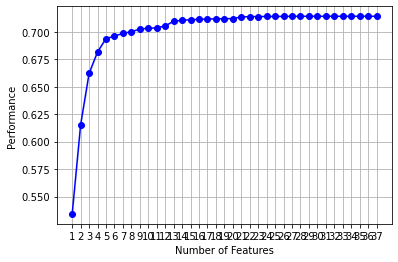

In [26]:
# 画出来，可以看到边际效益
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.grid()
plt.show()

In [28]:
all_data1 = all_data[['regDate',
                     'model',
                     'brand',
                     'bodyType',
                     'gearbox',
                     'kilometer',
                     'v_0',
                     'v_2',
                     'v_3',
                     'v_4',
                     'v_5',
                     'v_6',
                     'v_8',
                     'v_9',
                     'v_12',
                     'v_13',
                     'v_14',
                     'city',
                     'regDate_year',
                     'power_bin', 'price','kilometer',
                     'notRepairedDamage',
                     'fuelType_count',
                     'model_price_std',
                     'model_price_skew',
                     'model_v_3_max',
                     'model_v_0_median',
                     'brand_v_14_max',
                     'regDate_year_v_12_median',
                     'power_bin_v_0_min',
                     'kilometer_v_0_min',
                     'v_3_mins_v_3',
                     'v_3_div_v_11',
                     'v_3_multi_v_11',
                     'v_3_div_v_8',
                     'v_3_multi_v_8',
                     'v_0_multi_v_3',
                     'v_0_add_v_0',
                     'v_0_mins_v_0',
                     'v_0_div_v_0',
                     'v_0_multi_v_0',
                     'v_12_mins_v_3',
                     'v_12_multi_v_12',
                     'v_12_div_v_11',
                     'v_6_mins_v_6',
                     'v_6_add_v_11',
                     'v_6_mins_v_8',
                     'v_11_mins_v_11',
                     'v_8_multi_v_3',
                     'v_8_div_v_0',
                     'v_8_div_v_6',
                     'v_8_div_v_11',
                     'v_8_div_v_8',
                     'v_8_multi_v_8',
                     'model*v_3',
                     'model*v_13',
                     'brand*v_11',
                     'bodyType*v_4',
                     'bodyType*v_13',
                     'fuelType*v_10',
                     'gearbox*v_3',
                     'power_bin*v_3',
                     'power_bin*v_4',
                     'power_bin*v_7',
                     'power_bin*v_10',
                     'power_bin*v_13',
                     'kilometer*v_0',
                     'kilometer*v_1',
                     'kilometer*v_6',
                     'kilometer*v_9',
                     'kilometer*v_13',
                     'notRepairedDamage*v_2',
                     'notRepairedDamage*v_6',
                     'notRepairedDamage*v_10',
                     'model_brand_nunique',
                     'bodyType_3',
                     'bodyType_6',
                     'notRepairedDamage_1',
                     'regDate_year_24']].copy()
all_data1.shape

(200000, 80)